In [50]:
import os
from SuperMarketDataset import SegmentationDataset
import torch
import open3d as o3d
import os
import glob
import numpy as np
import h5py
from matplotlib import pyplot as plt
import random
import getpass
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


TARGET_OBJECT_DATASET_NAME = "ketchup_heinz_400ml_1200_4096_segmentation_40960_1200.h5"
SEGMENTAION_DATASET_PATH = r"D:\Datasets\MinimarketPointCloud\MiniMarket_point_clouds\4096\segmentation_dataset"
SEGMENTAION_MODEL_PATH = os.path.join(os.getcwd(), "object_segmentation_models")
if not os.path.exists(SEGMENTAION_MODEL_PATH):
    os.makedirs(SEGMENTAION_MODEL_PATH)


In [51]:
PC_SEGMMENTATION_DIR = r"D:\Datasets\MinimarketPointCloud\MiniMarket_point_clouds\4096\segmentation_dataset\ketchup_heinz_400ml_1200_4096_segmentation_40960_1200.h5"
                        
# Open the file in read mode
with h5py.File(PC_SEGMMENTATION_DIR, 'r') as f:
    # Read datasets
    seg_points = f["seg_points"][:]  
    seg_colors = f["seg_colors"][:]  
    seg_labels = f["seg_labels"][:]  
print(seg_points.shape)
print(seg_colors.shape)
print(seg_labels.shape)

(1200, 40960, 3)
(1200, 40960, 3)
(1200, 40960, 2)


Random sample index: 494


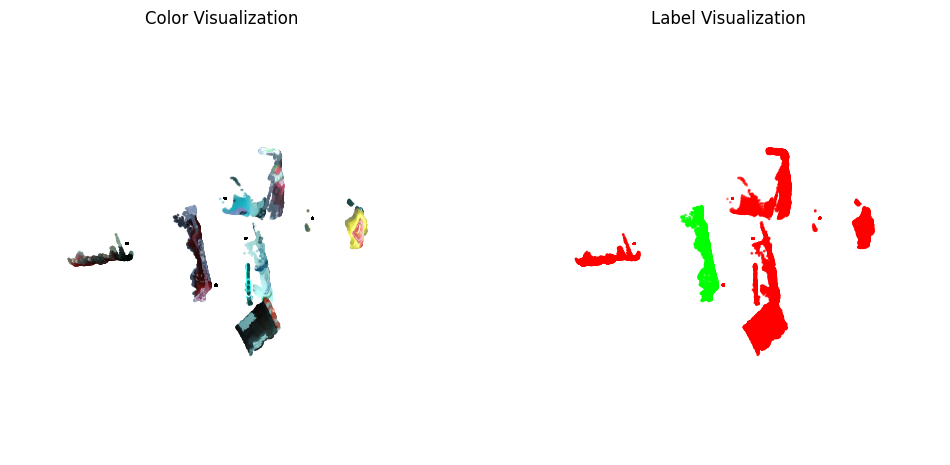

In [60]:
N = random.randint(0, seg_points.shape[0]-1)
print("Random sample index:", N)
points_sample = seg_points[N, :, :]
colors_sample = seg_colors[N, :, :]
labels_sample = np.where((seg_labels[N, :, :] == np.array([1, 0])).all(axis=1, keepdims=True), [0, 1, 0], [1, 0, 0])

fig = plt.figure(figsize=(12, 6))

# First subplot for color visualization
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
            c=colors_sample, s=1)
ax1.set_title("Color Visualization")
ax1.set_axis_off()

# Second subplot for label visualization
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
            c=labels_sample, s=1)
ax2.set_title("Label Visualization")
ax2.set_axis_off()

plt.show()



In [61]:
pcd_colors = o3d.geometry.PointCloud()
pcd_colors.points = o3d.utility.Vector3dVector(points_sample)
pcd_colors.colors = o3d.utility.Vector3dVector(colors_sample)
o3d.visualization.draw_geometries([pcd_colors], window_name="Color Visualization")

pcd_labels = o3d.geometry.PointCloud()
pcd_labels.points = o3d.utility.Vector3dVector(points_sample)
pcd_labels.colors = o3d.utility.Vector3dVector(labels_sample)
o3d.visualization.draw_geometries([pcd_labels], window_name="Label Visualization")



In [54]:
points_sample.shape, colors_sample.shape

((40960, 3), (40960, 3))

In [62]:
dataset_sample = np.concatenate((points_sample, colors_sample), axis=1).T[np.newaxis, :]
dataset_sample.shape

(1, 6, 40960)

In [63]:
from item_pointnet2_torch import PointNet2_SegHead

# Load the model
model_path = "PointNet2_object_segmentation_modelspointnet2_ketchup_heinz_400ml_1200_4096_segmentation_40960_1200.h5_seg_model_9.pth"
model_weights = torch.load(model_path)
model = PointNet2_SegHead(num_points=40960, m = 2)

# Load the state dictionary into the model
model.load_state_dict(model_weights)
model.eval()

# Convert dataset_samples to a PyTorch tensor and move it to the appropriate device
dataset_samples_tensor = torch.tensor(dataset_sample, dtype=torch.float32).to("cpu")
print(dataset_samples_tensor.shape)
# Perform inference
output = model(dataset_samples_tensor)[0]
output = torch.argmin(output, dim=2)
print(output.shape)

torch.Size([1, 6, 40960])
torch.Size([1, 40960])


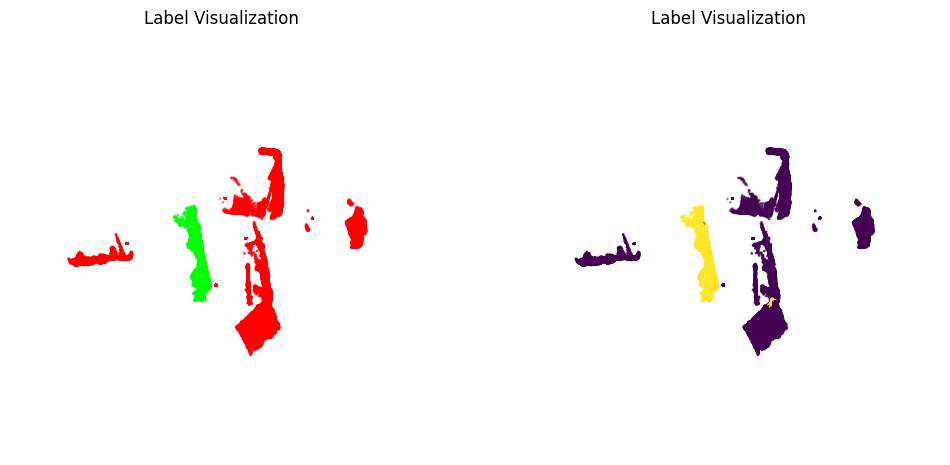

In [64]:
fig = plt.figure(figsize=(12, 6))

# first subplot for label visualization
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points_sample[:, 0], points_sample[:, 1], points_sample[:, 2],
            c=labels_sample, s=1)
ax1.set_title("Label Visualization")
ax1.set_axis_off()

# Second subplot for label visualization
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(dataset_samples_tensor[0, 0, :], dataset_samples_tensor[0, 1, :], dataset_samples_tensor[0, 2, :],
            c=output, s=1)
ax2.set_title("Label Visualization")
ax2.set_axis_off()


plt.show()

In [65]:
pcd_labels = o3d.geometry.PointCloud()
pcd_labels.points = o3d.utility.Vector3dVector(points_sample)
pcd_labels.colors = o3d.utility.Vector3dVector(labels_sample)
o3d.visualization.draw_geometries([pcd_labels], window_name="Label Visualization")

pcd_labels = o3d.geometry.PointCloud()
pcd_labels.points = o3d.utility.Vector3dVector(points_sample)
# Map the output tensor to RGB colors (e.g., 0 -> red, 1 -> green)
output_colors = np.where(output.T.numpy() == 0, [1, 0, 0], [0, 1, 0])  # Red for 0, Green for 1
pcd_labels.colors = o3d.utility.Vector3dVector(output_colors)
o3d.visualization.draw_geometries([pcd_labels], window_name="Label Visualization")
